# Cart-Pole Problem
<br>

<span style="font-family: monospace; font-size:18px;">
    In this notebook, we tackle the classic cart-pole balancing task, where the goal is to prevent a pole, hinged to a moving cart, from falling over. By applying forces to the cart's base, we aim to keep the pole upright. This setup provides a straightforward yet challenging environment to test different reinforcement learning algorithms.
</span>
<br>
<Br>

### Problem Description
<br>
<span style="font-family: monospace; font-size:18px;">
The cart-pole system is characterized by four continuous variables: the cart's position and velocity, and the pole's angle and angular velocity. Success is measured by the length of time the pole remains upright. Each episode ends either when the pole falls or the cart reaches the track's edge.
</span>
<br>
<br>
    
### Learning Algorithms
<br>
<span style="font-family: monospace; font-size:18px;">
We evaluate several foundational reinforcement learning algorithms on this task:
<br>
    
    
1. **Semi-gradient SARSA**: An on-policy algorithm using function approximation to update policies directly based on current estimates.
    
    
2. **Vanilla DQN (Deep Q-Network)**: Utilizes a straightforward neural network to estimate Q-values, with a basic experience replay.
    
    
3. **Vanilla Advantage Actor-Critic (A2C)**: We implement two versions of this basic actor-critic framework:
    
   - One for discrete action spaces, using separate networks for the policy (actor) and value (critic) estimations.
    
   - Another for continuous action spaces, adapting the actor to output a continuous action distribution.
</span>
    
<br>
    
### Reference
<br>
<span style="font-family: monospace; font-size:18px;">
Our approach is inspired by the cart-pole example from Chapter 6 of <i>Reinforcement Learning: An Introduction</i> by Richard S. Sutton and Andrew G. Barto. This foundational text provides valuable insights into function approximation in reinforcement learning, which we leverage in our implementations.
</span>
    
    
<br>
<br>
        
<span style="font-family: monospace; font-size:18px;">
These equations model the dynamics of the cart-pole system, which consists of a pole attached to a movable cart:

<br>
<br>
    

$$\begin{gathered}
N_c=\left(m_c+m_p\right) g-m_p l\left(\ddot{\theta} \sin \theta+\dot{\theta}^2 \cos \theta\right) \\
\ddot{\theta}=\frac{g \sin \theta+\cos \theta\left\{\frac{-F-m_p l \dot{\theta}^2\left[\sin \theta+\mu_c \operatorname{sgn}\left(N_c \dot{x}\right) \cos \theta\right]}{m_c+m_p}+\mu_c g \operatorname{sgn}\left(N_c \dot{x}\right)\right\}-\frac{\mu_p \dot{\theta}}{m_p l}}{l\left\{\frac{4}{3}-\frac{m_p \cos \theta}{m_c+m_p}\left[\cos \theta-\mu_c \operatorname{sgn}\left(N_c \dot{x}\right)\right]\right\}} \\
\ddot{x}=\frac{F+m_p l\left(\dot{\theta}^2 \sin \theta-\ddot{\theta} \cos \theta\right)-\mu_c N_c \operatorname{sgn}\left(N_c \dot{x}\right)}{m_c+m_p} .
\end{gathered}
$$ 
    
<br>
    
1. **Normal Force Calculation ($N_c$)**: This equation calculates the normal force exerted by the cart, considering the gravitational forces on both the cart ($m_c$) and the pole ($m_p$), the pole's angular motion, and the effect of its length ($l$).
2. **Angular Acceleration ($\ddot{\theta}$)**: This equation defines the angular acceleration of the pole relative to the cart. It factors in the gravitational force, the force exerted by the cart ($F$), friction coefficients ($\mu_c$, $\mu_p$), and the interaction between the cart's and pole's motions.
3. **Cart Acceleration ($\ddot{x}$)**: This equation describes the linear acceleration of the cart, incorporating forces from the cart movement, pole's angular velocity ($\dot{\theta}$), and angular acceleration, as well as the frictional force proportional to the normal force.
<br>
    
For a deeper dive into the mathematics and applications, refer to the detailed discussion in the provided [source](https://coneural.org/florian/papers/05_cart_pole.pdf).
</span>

## Import libraries

In [1]:
import torch
import torch.optim as optim
from config import ACTIONS, THETA_DOT_BOUNDS, X_DOT_BOUNDS
from cart_pole_class import CartPole
from tile_coder import TileCoder
from replay_memory_class import ReplayMemory
from semi_gradient_sarsa_agent_class import SemiGradientSarsaAgent
from ann_model_classes import FCN, SoftmaxFCN, GaussianFCN
from model_handler_classes import ModelHandler, ActorModelHandler
from dqn_agent_class import DQNAgent
from actor_critic_agent_class import ActorCriticAgent
from model_utils import train, EarlyStopCallback, DivergenceCallback
from epsilon_decay_class import EpsilonDecay
from utils import plot_rewards_per_episode, time_to_learn, plot_time_to_learn

## Evaluation Criteria

<br>
<br>

<span style="font-family: monospace; font-size:18px;">
We consider the agent to have reached the goal when it achieves a reward of 200 (corresponding to 200 steps) in 10 independent evaluation episodes.</span>

## Discrete Actions

### Semi-gradient SARSA

#### Environment

In [2]:
env = CartPole(theta_dot_bounds=THETA_DOT_BOUNDS, x_dot_bounds=X_DOT_BOUNDS)

#### Parameters

In [3]:
params = {
    'alpha': 0.41234755577480847,
    'num_tilings': 14,
    'tiles_per_dimension': [6, 6, 6, 6],
    'epsilon_end': 0.018333047451484605,
    'last_episode': 40
} 

#### Sarsa Agent 

In [4]:
tile_coder = TileCoder(tiles_per_dimension=params["tiles_per_dimension"], num_tilings=params["num_tilings"])
epsilon = EpsilonDecay(epsilon_start=1.0,
                       epsilon_end=params["epsilon_end"],
                       last_episode=params["last_episode"],
                       decay_method='linear'
)
sarsa_agent = SemiGradientSarsaAgent(env, ACTIONS, tile_coder, epsilon, alpha=params["alpha"], gamma=0.99)

#### Run Simulation

In [5]:
%%time

early_stop_callback = EarlyStopCallback(threshold=200)

sarsa_agent.reset_simulation()

results = train(sarsa_agent,
                train_episodes=1000,
                evaluation_episodes=10,
                evaluation_interval=1,
                callbacks=[early_stop_callback]
)

Episode 1/1000: Evaluation Score = 8.8
Episode 2/1000: Evaluation Score = 7.7
Episode 3/1000: Evaluation Score = 7.7
Episode 4/1000: Evaluation Score = 8.2
Episode 5/1000: Evaluation Score = 8.3
Episode 6/1000: Evaluation Score = 8.3
Episode 7/1000: Evaluation Score = 8.7
Episode 8/1000: Evaluation Score = 8.2
Episode 9/1000: Evaluation Score = 8.2
Episode 10/1000: Evaluation Score = 8.3
Episode 11/1000: Evaluation Score = 8.5
Episode 12/1000: Evaluation Score = 8.1
Episode 13/1000: Evaluation Score = 8.0
Episode 14/1000: Evaluation Score = 8.2
Episode 15/1000: Evaluation Score = 8.2
Episode 16/1000: Evaluation Score = 8.3
Episode 17/1000: Evaluation Score = 8.3
Episode 18/1000: Evaluation Score = 8.5
Episode 19/1000: Evaluation Score = 8.4
Episode 20/1000: Evaluation Score = 8.0
Episode 21/1000: Evaluation Score = 7.8
Episode 22/1000: Evaluation Score = 8.4
Episode 23/1000: Evaluation Score = 8.0
Episode 24/1000: Evaluation Score = 7.8
Episode 25/1000: Evaluation Score = 8.6
Episode 2

Episode 199/1000: Evaluation Score = 121.9
Episode 200/1000: Evaluation Score = 113.0
Episode 201/1000: Evaluation Score = 118.5
Episode 202/1000: Evaluation Score = 112.3
Episode 203/1000: Evaluation Score = 118.2
Episode 204/1000: Evaluation Score = 111.9
Episode 205/1000: Evaluation Score = 113.0
Episode 206/1000: Evaluation Score = 112.2
Episode 207/1000: Evaluation Score = 117.9
Episode 208/1000: Evaluation Score = 116.6
Episode 209/1000: Evaluation Score = 117.8
Episode 210/1000: Evaluation Score = 117.3
Episode 211/1000: Evaluation Score = 115.1
Episode 212/1000: Evaluation Score = 116.5
Episode 213/1000: Evaluation Score = 117.7
Episode 214/1000: Evaluation Score = 124.3
Episode 215/1000: Evaluation Score = 118.6
Episode 216/1000: Evaluation Score = 121.3
Episode 217/1000: Evaluation Score = 118.1
Episode 218/1000: Evaluation Score = 122.7
Episode 219/1000: Evaluation Score = 119.8
Episode 220/1000: Evaluation Score = 120.6
Episode 221/1000: Evaluation Score = 120.2
Episode 222

Episode 390/1000: Evaluation Score = 135.1
Episode 391/1000: Evaluation Score = 132.6
Episode 392/1000: Evaluation Score = 122.2
Episode 393/1000: Evaluation Score = 125.4
Episode 394/1000: Evaluation Score = 127.1
Episode 395/1000: Evaluation Score = 124.0
Episode 396/1000: Evaluation Score = 122.1
Episode 397/1000: Evaluation Score = 130.6
Episode 398/1000: Evaluation Score = 143.9
Episode 399/1000: Evaluation Score = 130.4
Episode 400/1000: Evaluation Score = 128.7
Episode 401/1000: Evaluation Score = 133.2
Episode 402/1000: Evaluation Score = 128.5
Episode 403/1000: Evaluation Score = 122.8
Episode 404/1000: Evaluation Score = 127.4
Episode 405/1000: Evaluation Score = 121.7
Episode 406/1000: Evaluation Score = 125.9
Episode 407/1000: Evaluation Score = 130.0
Episode 408/1000: Evaluation Score = 124.5
Episode 409/1000: Evaluation Score = 131.8
Episode 410/1000: Evaluation Score = 131.4
Episode 411/1000: Evaluation Score = 132.2
Episode 412/1000: Evaluation Score = 122.2
Episode 413

Episode 581/1000: Evaluation Score = 155.1
Episode 582/1000: Evaluation Score = 135.5
Episode 583/1000: Evaluation Score = 128.2
Episode 584/1000: Evaluation Score = 133.0
Episode 585/1000: Evaluation Score = 151.4
Episode 586/1000: Evaluation Score = 132.9
Episode 587/1000: Evaluation Score = 128.9
Episode 588/1000: Evaluation Score = 134.0
Episode 589/1000: Evaluation Score = 144.0
Episode 590/1000: Evaluation Score = 126.4
Episode 591/1000: Evaluation Score = 137.3
Episode 592/1000: Evaluation Score = 133.1
Episode 593/1000: Evaluation Score = 149.8
Episode 594/1000: Evaluation Score = 147.9
Episode 595/1000: Evaluation Score = 130.3
Episode 596/1000: Evaluation Score = 128.9
Episode 597/1000: Evaluation Score = 129.5
Episode 598/1000: Evaluation Score = 163.7
Episode 599/1000: Evaluation Score = 150.9
Episode 600/1000: Evaluation Score = 139.8
Episode 601/1000: Evaluation Score = 163.2
Episode 602/1000: Evaluation Score = 128.0
Episode 603/1000: Evaluation Score = 143.0
Episode 604

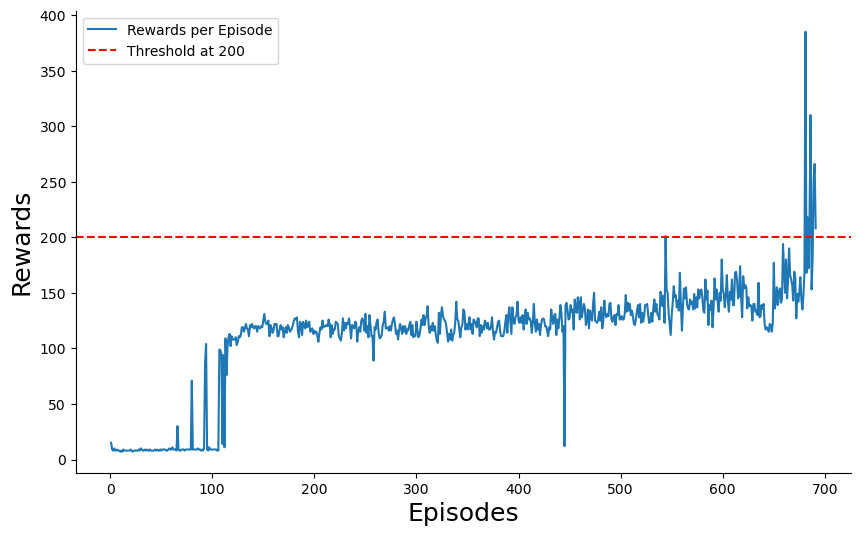

In [6]:
plot_rewards_per_episode(results)

### Vanilla DQN

#### Environment

In [7]:
env = CartPole()

#### Parameters

In [8]:
params = {
    'batch_size': 128,
    'learning_rate': 0.0009249903709753625,
    'layers': 2,
    'n_hidden_units': 256,
    'leaky_relu_alpha': 0.0013767302741053737,
    'epsilon_end': 0.006714761425975067,
    'last_episode': 50
}

#### Model

In [9]:
model = FCN(hidden_units=[params["n_hidden_units"]] * params["layers"],
            activation=torch.nn.LeakyReLU(negative_slope=params["leaky_relu_alpha"])
)
optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

#### DQN Agent

In [10]:
model_handler = ModelHandler(model, optimizer)
replay_memory = ReplayMemory(memory_size=100000)
epsilon = EpsilonDecay(epsilon_start=1.0,
                       epsilon_end=params["epsilon_end"],
                       last_episode=params["last_episode"],
                       decay_method='linear'
)

dqn_agent = DQNAgent(env, ACTIONS, model_handler, replay_memory, epsilon, gamma=0.99, batch_size=params["batch_size"])

#### Run Simulation

In [11]:
early_stop_callback = EarlyStopCallback(threshold=200)

dqn_agent.reset_simulation()

results = train(dqn_agent,
                train_episodes=1000,
                evaluation_episodes=10,
                evaluation_interval=1,
                callbacks=[early_stop_callback]
)

Episode 1/1000: Evaluation Score = 7.7
Episode 2/1000: Evaluation Score = 7.6
Episode 3/1000: Evaluation Score = 7.5
Episode 4/1000: Evaluation Score = 7.4
Episode 5/1000: Evaluation Score = 7.5
Episode 6/1000: Evaluation Score = 7.9
Episode 7/1000: Evaluation Score = 7.8
Episode 8/1000: Evaluation Score = 7.3
Episode 9/1000: Evaluation Score = 7.1
Episode 10/1000: Evaluation Score = 7.7
Episode 11/1000: Evaluation Score = 7.5
Episode 12/1000: Evaluation Score = 7.5
Episode 13/1000: Evaluation Score = 7.3
Episode 14/1000: Evaluation Score = 7.6
Episode 15/1000: Evaluation Score = 7.9
Episode 16/1000: Evaluation Score = 7.7
Episode 17/1000: Evaluation Score = 7.7
Episode 18/1000: Evaluation Score = 7.4
Episode 19/1000: Evaluation Score = 7.6
Episode 20/1000: Evaluation Score = 7.7
Episode 21/1000: Evaluation Score = 7.7
Episode 22/1000: Evaluation Score = 7.3
Episode 23/1000: Evaluation Score = 7.2
Episode 24/1000: Evaluation Score = 7.8
Episode 25/1000: Evaluation Score = 8.1
Episode 2

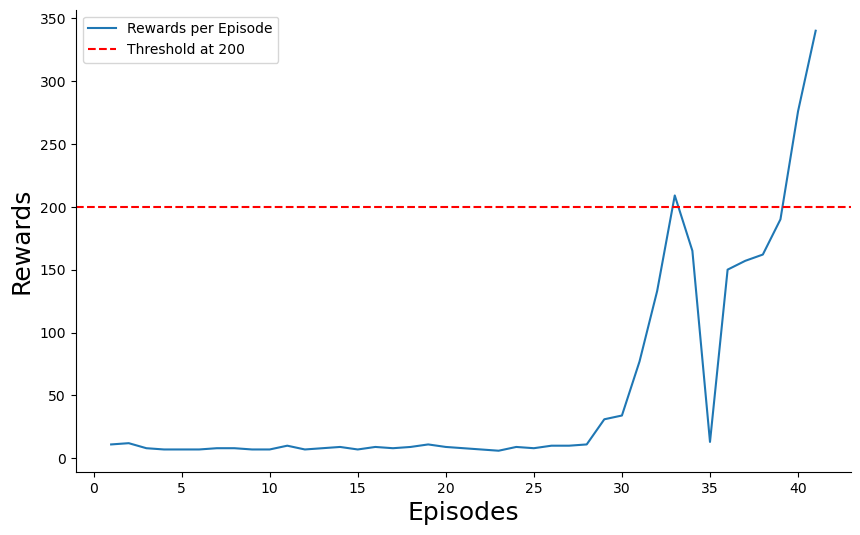

In [12]:
plot_rewards_per_episode(results)

### Vanilla Actor-Critic

#### Environment

In [13]:
env = CartPole()

#### Parameters

In [14]:
params = {
    'batch_size': 256,
    'critic_learning_rate': 0.051752811229065984,
    'actor_learning_rate': 2.112222126769605e-06,
    'critic_layers': 2,
    'actor_layers': 2,
    'critic_n_hidden_units': 32,
    'actor_n_hidden_units': 1024,
    'critic_leaky_relu_alpha': 0.0049533632824815136,
    'actor_leaky_relu_alpha': 0.0024256162642546128
}

#### Critic Model

In [15]:
critic_model = FCN(output_dim=1,
                   hidden_units=[params["critic_n_hidden_units"]] * params["critic_layers"],
                   activation=torch.nn.LeakyReLU(negative_slope=params["critic_leaky_relu_alpha"])
)
critic_optimizer = optim.Adam(critic_model.parameters(), lr=params["critic_learning_rate"])
critic_model_handler = ModelHandler(critic_model, critic_optimizer)

#### Actor Model

In [16]:
actor_model = SoftmaxFCN(output_dim=2,
                         hidden_units=[params["actor_n_hidden_units"]] * params["actor_layers"],
                         activation=torch.nn.LeakyReLU(negative_slope=params["actor_leaky_relu_alpha"])
)
actor_optimizer = optim.Adam(actor_model.parameters(), lr=params["actor_learning_rate"])
actor_model_handler = ActorModelHandler(actor_model, actor_optimizer)

#### Actor-Critic Agent

In [17]:
replay_memory = ReplayMemory(memory_size=100000)

actor_critic_agent = ActorCriticAgent(env,
                                      critic_model_handler,
                                      actor_model_handler,
                                      replay_memory,
                                      actions=ACTIONS,
                                      batch_size=params["batch_size"])

#### Run Simulation

In [18]:
%%time

early_stop_callback = EarlyStopCallback(threshold=200)

actor_critic_agent.reset_simulation()

results = train(actor_critic_agent,
                train_episodes=1000,
                evaluation_episodes=10,
                evaluation_interval=1,
                callbacks=[early_stop_callback]
)

Episode 1/1000: Evaluation Score = 16.9
Episode 2/1000: Evaluation Score = 15.0
Episode 3/1000: Evaluation Score = 20.1
Episode 4/1000: Evaluation Score = 18.7
Episode 5/1000: Evaluation Score = 22.3
Episode 6/1000: Evaluation Score = 18.9
Episode 7/1000: Evaluation Score = 21.2
Episode 8/1000: Evaluation Score = 26.5
Episode 9/1000: Evaluation Score = 23.6
Episode 10/1000: Evaluation Score = 16.8
Episode 11/1000: Evaluation Score = 20.7
Episode 12/1000: Evaluation Score = 14.2
Episode 13/1000: Evaluation Score = 27.1
Episode 14/1000: Evaluation Score = 21.8
Episode 15/1000: Evaluation Score = 17.3
Episode 16/1000: Evaluation Score = 19.0
Episode 17/1000: Evaluation Score = 17.1
Episode 18/1000: Evaluation Score = 22.7
Episode 19/1000: Evaluation Score = 17.1
Episode 20/1000: Evaluation Score = 19.7
Episode 21/1000: Evaluation Score = 28.9
Episode 22/1000: Evaluation Score = 14.1
Episode 23/1000: Evaluation Score = 28.3
Episode 24/1000: Evaluation Score = 18.2
Episode 25/1000: Evaluati

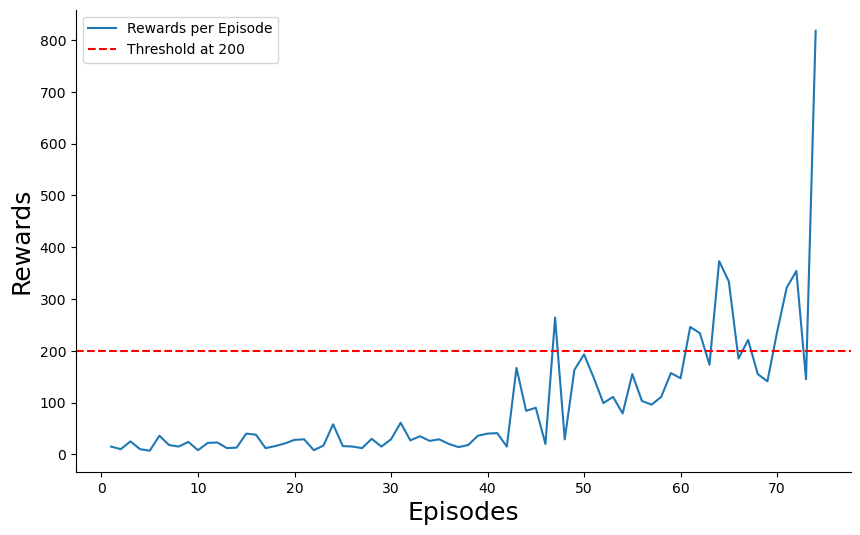

In [19]:
plot_rewards_per_episode(results)

## Continuous Actions

### Vanilla Actor-Critic

#### Environment

In [20]:
env = CartPole()

#### Parameters

In [21]:
params = {
    'batch_size': 256,
    'critic_learning_rate': 0.04277709556820966,
    'actor_learning_rate': 4.930545056813237e-06,
    'critic_layers': 2, 'actor_layers': 2,
    'critic_n_hidden_units': 32,
    'actor_n_hidden_units': 512,
    'critic_leaky_relu_alpha': 0.0954730924420421,
    'actor_leaky_relu_alpha': 0.17972045013924107
}

#### Critic Model

In [22]:
critic_model = FCN(output_dim=1,
                   hidden_units=[params["critic_n_hidden_units"]] * params["critic_layers"],
                   activation=torch.nn.LeakyReLU(negative_slope=params["critic_leaky_relu_alpha"])
)
critic_optimizer = optim.Adam(critic_model.parameters(), lr=params["critic_learning_rate"])
critic_model_handler = ModelHandler(critic_model, critic_optimizer)

#### Actor Model

In [23]:
actor_model = GaussianFCN(hidden_units=[params["actor_n_hidden_units"]] * params["actor_layers"],
                          activation=torch.nn.LeakyReLU(negative_slope=params["actor_leaky_relu_alpha"])
)
actor_optimizer = optim.Adam(actor_model.parameters(), lr=params["actor_learning_rate"])
actor_model_handler = ActorModelHandler(actor_model, actor_optimizer)

#### Actor-Critic Agent

In [24]:
replay_memory = ReplayMemory(memory_size=100000)

continuous_actor_critic_agent = ActorCriticAgent(env,
                                                 critic_model_handler,
                                                 actor_model_handler,
                                                 replay_memory,
                                                 batch_size=params["batch_size"]
)

#### Run Simulation

In [25]:
%%time

early_stop_callback = EarlyStopCallback(threshold=200)

continuous_actor_critic_agent.reset_simulation()

results = train(continuous_actor_critic_agent,
                train_episodes=1000,
                evaluation_episodes=10,
                evaluation_interval=1,
                callbacks=[early_stop_callback]
)

Episode 1/1000: Evaluation Score = 22.3
Episode 2/1000: Evaluation Score = 23.9
Episode 3/1000: Evaluation Score = 27.8
Episode 4/1000: Evaluation Score = 22.8
Episode 5/1000: Evaluation Score = 17.8
Episode 6/1000: Evaluation Score = 26.1
Episode 7/1000: Evaluation Score = 22.9
Episode 8/1000: Evaluation Score = 22.4
Episode 9/1000: Evaluation Score = 22.3
Episode 10/1000: Evaluation Score = 25.8
Episode 11/1000: Evaluation Score = 28.2
Episode 12/1000: Evaluation Score = 22.6
Episode 13/1000: Evaluation Score = 26.7
Episode 14/1000: Evaluation Score = 30.5
Episode 15/1000: Evaluation Score = 24.2
Episode 16/1000: Evaluation Score = 28.7
Episode 17/1000: Evaluation Score = 37.2
Episode 18/1000: Evaluation Score = 26.0
Episode 19/1000: Evaluation Score = 30.5
Episode 20/1000: Evaluation Score = 37.1
Episode 21/1000: Evaluation Score = 31.1
Episode 22/1000: Evaluation Score = 42.7
Episode 23/1000: Evaluation Score = 35.8
Episode 24/1000: Evaluation Score = 51.3
Episode 25/1000: Evaluati

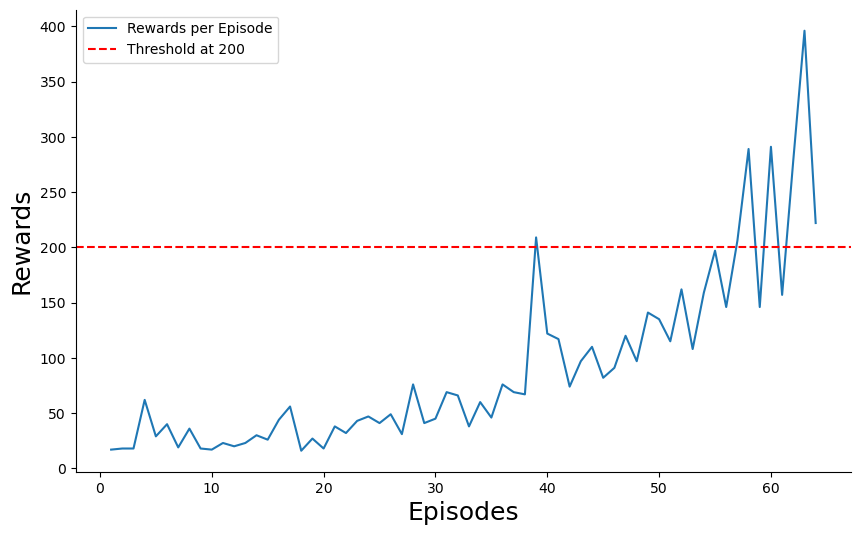

In [26]:
plot_rewards_per_episode(results)

## Model Comparison

In [27]:
sarsa_ttl = time_to_learn(sarsa_agent, iterations=200)
dqn_ttl = time_to_learn(dqn_agent, iterations=200)
actor_critic_ttl = time_to_learn(actor_critic_agent, iterations=200)
continuous_actor_critic_ttl = time_to_learn(continuous_actor_critic_agent, iterations=200)

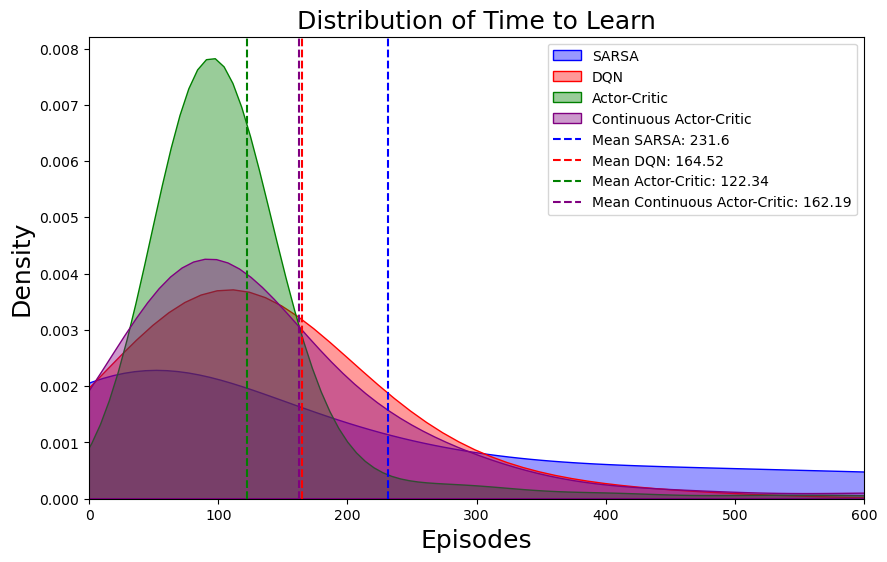

In [28]:
plot_time_to_learn(sarsa_ttl, dqn_ttl, actor_critic_ttl, continuous_actor_critic_ttl)